# Video lesson \#15 notebook

## Part 1: `Pandas` - counting, sorting, and grouping data

In [ ]:
# # This code allows Cartopy to work with Google Colab
# # Run this code once per session, then comment it out
# !grep '^deb ' /etc/apt/sources.list | \
#   sed 's/^deb /deb-src /g' | \
#   tee /etc/apt/sources.list.d/deb-src.list
# !apt-get -qq update
# !apt-get -qq build-dep python3-cartopy
# !pip uninstall -y shapely
# !pip install shapely --no-binary shapely
# !pip install cartopy

# Import useful libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats, interpolate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Give Colab access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load data from 2013 Puget Sound marine mammal aerial survey

<img src="http://drive.google.com/uc?export=view&id=1NZF-zQ8VjE7Jm2BgqQP7aGS1Z9aRhpc4" width="700">

*Image: Harbor porpoises. Credit: [Bill Keener](https://medium.com/the-ark-newspaper/a-comeback-story-harbor-porpoises-return-to-the-bay-d1ed871e2790) / Golden Gate Cetacean Research.*

**Data source:** https://obis.org/dataset/0e80dc63-b47c-423a-8e34-362f3171ea18

**Background:** "Marine mammal aerial surveys were conducted from 30 August through 4 September 2013 in the Pacific Northwest inland Puget Sound waters. This effort was in support of Marine Mammal Protection Act permit monitoring requirements for the U.S. Navy to conduct marine mammal studies in waters on or adjacent to U.S. Naval installations in the inland Puget Sound Region... . There were 779 marine mammal sightings of over 1716 animals representing 5785 km of flight..."

In [ ]:
# Load CSV
# Note that we're parsing the "eventDate" column as datetimes
#   and setting the "recordNumber" column as the index
mm_filepath = '/content/drive/MyDrive/OCEAN 215 - Autumn \'20/OCEAN 215 - Autumn \'20 - Course documents/Video lesson slides and notebooks/2020-11-22 - lesson #15 data/puget_sound_marine_mammal_surveys.csv'
mm_data = pd.read_csv(mm_filepath,parse_dates=['eventDate'],index_col='recordNumber')

# View data
display(mm_data)

,individualCount,eventDate,decimalLatitude,decimalLongitude,scientificName,kingdom,phylum,class,order,family,genus,specificEpithet,taxonRank,vernacularName,taxonRemarks
recordNumber,,,,,,,,,,,,,,,
1106_335,1,2013-09-01 10:34:52,47.710125,-122.839587,Elasmobranchii,Animalia,Chordata,Chondrichthyes,NaN,NaN,NaN,NaN,Subclass,cartilaginous fishes,"Taxon recorded as ""Shark"" by the provider"
1106_18,1,2013-08-30 10:39:25,48.142590,-122.625822,Mammalia,Animalia,Chordata,Mammalia,NaN,NaN,NaN,NaN,Class,mammals,"Taxon recorded as ""Unidentified Marine Mammal""..."
1106_84,1,2013-08-30 14:53:26,47.577825,-122.999232,Mammalia,Animalia,Chordata,Mammalia,NaN,NaN,NaN,NaN,Class,mammals,"Taxon recorded as ""Unidentified Small Marine M..."
1106_435,3,2013-09-01 16:36:17,47.611800,-122.467788,Mammalia,Animalia,Chordata,Mammalia,NaN,NaN,NaN,NaN,Class,mammals,"Taxon recorded as ""Unidentified Marine Mammal""..."
1106_706,2,2013-09-03 16:02:45,47.309638,-122.694075,Mammalia,Animalia,Chordata,Mammalia,NaN,NaN,NaN,NaN,Class,mammals,"Taxon recorded as ""Unidentified Small Marine M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106_515,2,2013-09-02 13:07:44,48.145858,-122.415262,Phocoenidae,Animalia,Chordata,Mammalia,Cetacea,Phocoenidae,NaN,NaN,Family,porpoises,"Taxon recorded as ""Unidentified Porpoise"" by t..."
1106_394,1,2013-09-01 14:29:11,47.245972,-122.601694,Phocoenidae,Animalia,Chordata,Mammalia,Cetacea,Phocoenidae,NaN,NaN,Family,porpoises,"Taxon recorded as ""Unidentified Porpoise"" by t..."
1106_20,2,2013-08-30 10:41:00,48.143300,-122.693150,Phocoenidae,Animalia,Chordata,Mammalia,Cetacea,Phocoenidae,NaN,NaN,Family,porpoises,"Taxon recorded as ""Unidentified Porpoise"" by t..."


### Count unique rows of a Pandas Series using `.value_counts()`

Think of this like creating a histogram.

API reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html

In [ ]:
# Count number of rows for each animal
#
# This shows that the most common animal logged is the harbor seal
display(mm_data['vernacularName'].value_counts())

Harbor Seal             675
Harbor Porpoise          66
California Sealion       15
mammals                  12
porpoises                 5
pinnipeds                 4
Risso's Dolphin           2
cartilaginous fishes      1
Name: vernacularName, dtype: int64

In [ ]:
# Count number of rows for each entry recording a certain number of animals
#
# This shows that most entries record just a single animal, but one entry recorded 150 animals!
display(mm_data['individualCount'].value_counts())

1      643
2       71
3       19
5       10
10       5
4        5
25       5
8        4
6        3
12       3
7        2
100      1
15       1
9        1
20       1
27       1
40       1
50       1
55       1
65       1
150      1
Name: individualCount, dtype: int64

### Sort a `Pandas` DataFrame by column label using `.sort_values()`

The main argument is the column label. You can choose to modify the object "in-place" by setting `inplace=True`.

API reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

In [ ]:
# Sort by date
mm_data = mm_data.sort_values('eventDate')     # Option 1: create new copy, reassign to variable
mm_data.sort_values('eventDate',inplace=True)  # Option 2: modify in-place

# Display sorted date column of DataFrame
# Note the index ("recordNumber") now appears to be sorted, too
display(mm_data['eventDate'])

recordNumber
1106_1     2013-08-30 09:16:32
1106_2     2013-08-30 09:16:32
1106_3     2013-08-30 09:16:32
1106_4     2013-08-30 09:42:16
1106_5     2013-08-30 09:42:25
                   ...        
1106_794   2013-09-04 10:01:03
1106_795   2013-09-04 10:02:01
1106_796   2013-09-04 10:02:21
1106_797   2013-09-04 10:02:35
1106_798   2013-09-04 10:02:37
Name: eventDate, Length: 780, dtype: datetime64[ns]

### Overview of `.groupby()`: the "split-apply-combine" method



By "group by", we are referring to a process involving the following steps:

1. **Splitting** the data into groups based on some column or criteria

2. **Applying** a function to each group independently, often one that aggregates each group (i.e. a summary statistic like `.mean()`)

3. **Combining** the results into a new DataFrame

We use the following syntax:

> `df.groupby(<label or labels>).<function>()`

API reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

### Splitting the DataFrame using `.groupby()`

We specify a single column name as an argument. This returns a `GroupBy` object, which is not useful to us until we call a function on it.

In [ ]:
# Let's group the data using the column label "vernacularName" (the type of animal)
mm_data.groupby('vernacularName')

### Learning more about a GroupBy object

Attributes and functions shown in this section:
* `.groups`
* `.count()`
* `.get_group()`
* `.first()` and `.last()`

In [ ]:
# .groups returns a dictionary with each group label and the index values within that group
mm_data.groupby('vernacularName').groups

{'California Sealion': ['1106_1', '1106_2', '1106_163', '1106_182', '1106_242', '1106_245', '1106_265', '1106_486', '1106_527', '1106_566', '1106_592', '1106_728', '1106_729', '1106_747', '1106_758'], 'Harbor Porpoise': ['1106_21', '1106_27', '1106_28', '1106_29', '1106_30', '1106_36', '1106_43', '1106_65', '1106_83', '1106_117', '1106_121', '1106_123', '1106_136', '1106_138', '1106_208', '1106_266', '1106_268', '1106_269', '1106_270', '1106_277', '1106_282', '1106_285', '1106_286', '1106_287', '1106_298', '1106_315', '1106_324', '1106_325', '1106_327', '1106_337', '1106_383', '1106_418', '1106_436', '1106_446', '1106_450', '1106_453', '1106_454', '1106_455', '1106_464', '1106_465', '1106_466', '1106_467', '1106_468', '1106_469', '1106_477', '1106_478', '1106_509', '1106_510', '1106_511', '1106_538', '1106_690', '1106_735', '1106_742', '1106_744', '1106_746', '1106_750', '1106_751', '1106_752', '1106_753', '1106_754', '1106_755', '1106_756', '1106_757', '1106_762', '1106_763', '1106_79

In [ ]:
# Recall that a dictionary is an object with key-value pairs
# and we can get the keys using .keys()
#
# Then we can convert to a list using list()
list(mm_data.groupby('vernacularName').groups.keys())

['California Sealion',
 'Harbor Porpoise',
 'Harbor Seal',
 "Risso's Dolphin",
 'cartilaginous fishes',
 'mammals',
 'pinnipeds',
 'porpoises']

In [ ]:
# .count() is similar to .value_counts() — it counts the number of rows with data in each group, for each column
#
# Here, notice that some columns are missing data for some groups.
# For instance, there's no order/family/genus specified for the generic label "mammals", probably because
# the scientists used that label for instances where they couldn't determine what type of mammal they had seen.
mm_data.groupby('vernacularName').count()

,individualCount,eventDate,decimalLatitude,decimalLongitude,scientificName,kingdom,phylum,class,order,family,genus,specificEpithet,taxonRank,taxonRemarks
vernacularName,,,,,,,,,,,,,,
California Sealion,15,15,15,15,15,15,15,15,15,15,15,15,15,15
Harbor Porpoise,66,66,66,66,66,66,66,66,66,66,66,66,66,66
Harbor Seal,675,675,675,675,675,675,675,675,675,675,675,675,675,675
Risso's Dolphin,2,2,2,2,2,2,2,2,2,2,2,2,2,2
cartilaginous fishes,1,1,1,1,1,1,1,1,0,0,0,0,1,1
mammals,12,12,12,12,12,12,12,12,0,0,0,0,12,12
pinnipeds,4,4,4,4,4,4,4,4,4,0,0,0,4,4
porpoises,5,5,5,5,5,5,5,5,5,5,0,0,5,5


In [ ]:
# Use .get_group() to get a subset of the original DataFrame
mm_data.groupby('vernacularName').get_group('Risso\'s Dolphin')

,individualCount,eventDate,decimalLatitude,decimalLongitude,scientificName,kingdom,phylum,class,order,family,genus,specificEpithet,taxonRank,vernacularName,taxonRemarks
recordNumber,,,,,,,,,,,,,,,
1106_239,2,2013-08-31 11:19:34,47.543402,-122.444832,Grampus griseus,Animalia,Chordata,Mammalia,Cetacea,Delphinidae,Grampus,griseus,Species,Risso's Dolphin,"Taxon recorded as ""Risso's Dolphin"" by the pro..."
1106_767,2,2013-09-04 08:56:50,47.732910,-122.421702,Grampus griseus,Animalia,Chordata,Mammalia,Cetacea,Delphinidae,Grampus,griseus,Species,Risso's Dolphin,"Taxon recorded as ""Risso's Dolphin"" by the pro..."


In [ ]:
# Column indexing using brackets ([]) works normally on grouped data
mm_data.groupby('vernacularName').get_group('Risso\'s Dolphin')['eventDate']

recordNumber
1106_239   2013-08-31 11:19:34
1106_767   2013-09-04 08:56:50
Name: eventDate, dtype: datetime64[ns]

In [ ]:
# Use .first() or .last() to get the first or last rows in each group
# 
# From this, we learn that the first sighting of harbor seals was on August 30, and that
# the researchers saw 25 harbor seals in that sighting.
mm_data.groupby('vernacularName').first()

,individualCount,eventDate,decimalLatitude,decimalLongitude,scientificName,kingdom,phylum,class,order,family,genus,specificEpithet,taxonRank,taxonRemarks
vernacularName,,,,,,,,,,,,,,
California Sealion,1,2013-08-30 09:16:32,47.781028,-122.466250,Zalophus californianus,Animalia,Chordata,Mammalia,Carnivora,Otariidae,Zalophus,californianus,Species,"Taxon recorded as ""California Sea Lion"" by the..."
Harbor Porpoise,1,2013-08-30 10:41:23,48.149585,-122.703068,Phocoena phocoena,Animalia,Chordata,Mammalia,Cetacea,Phocoenidae,Phocoena,phocoena,Species,"Taxon recorded as ""Harbor Porpoise"" by the pro..."
Harbor Seal,25,2013-08-30 09:42:16,48.377565,-122.560668,Phoca vitulina,Animalia,Chordata,Mammalia,Carnivora,Phocidae,Phoca,vitulina,Species,"Taxon recorded as ""Harbor Seal"" by the provider"
Risso's Dolphin,2,2013-08-31 11:19:34,47.543402,-122.444832,Grampus griseus,Animalia,Chordata,Mammalia,Cetacea,Delphinidae,Grampus,griseus,Species,"Taxon recorded as ""Risso's Dolphin"" by the pro..."
cartilaginous fishes,1,2013-09-01 10:34:52,47.710125,-122.839587,Elasmobranchii,Animalia,Chordata,Chondrichthyes,NaN,NaN,NaN,NaN,Subclass,"Taxon recorded as ""Shark"" by the provider"
mammals,1,2013-08-30 10:39:25,48.142590,-122.625822,Mammalia,Animalia,Chordata,Mammalia,NaN,NaN,NaN,NaN,Class,"Taxon recorded as ""Unidentified Marine Mammal""..."
pinnipeds,5,2013-08-30 09:16:32,47.781018,-122.466263,Caniformia,Animalia,Chordata,Mammalia,Carnivora,NaN,NaN,NaN,Suborder,"Taxon recorded as ""Unidentified Pinniped"" by t..."
porpoises,2,2013-08-30 10:41:00,48.143300,-122.693150,Phocoenidae,Animalia,Chordata,Mammalia,Cetacea,Phocoenidae,NaN,NaN,Family,"Taxon recorded as ""Unidentified Porpoise"" by t..."


### Applying functions to aggregate data within groups

In the "split-apply-combine" paradigm, this is the **apply** and **combine** part.

You can apply NumPy functions like `.mean()`, `.sum()`, `.median()`, `.max()`, `.min()`, and `.std()` to calculate statistics for each numerical column of a grouped DataFrame (a `GroupBy` object).

You can also call `.describe()` on a grouped DataFrame to get a number of useful summary statistics.

In [ ]:
# Calculate averages over animal groups
#
# From this, we learn that the average location where California sea lions were sighted
# was 47.719°N, 122.585°W.
mm_data.groupby('vernacularName').mean()

,individualCount,decimalLatitude,decimalLongitude
vernacularName,,,
California Sealion,1.333333,47.719321,-122.585271
Harbor Porpoise,2.242424,47.822614,-122.585301
Harbor Seal,2.241481,47.575504,-122.654574
Risso's Dolphin,2.000000,47.638156,-122.433267
cartilaginous fishes,1.000000,47.710125,-122.839587
mammals,1.333333,47.568643,-122.571448
pinnipeds,2.250000,47.810798,-122.503737
porpoises,1.400000,47.816668,-122.585215


In [ ]:
# Calculate sums over animal groups
#
# From this, we learn that the researchers saw a total of 1513 harbor seals.
# Note that it doesn't really make sense to calculate the sum of latitude or longitude, but Pandas does it anyway.
mm_data.groupby('vernacularName').sum()

,individualCount,decimalLatitude,decimalLongitude
vernacularName,,,
California Sealion,20,715.789815,-1838.779060
Harbor Porpoise,148,3156.292495,-8090.629848
Harbor Seal,1513,32113.465014,-82791.837713
Risso's Dolphin,4,95.276312,-244.866534
cartilaginous fishes,1,47.710125,-122.839587
mammals,16,570.823710,-1470.857377
pinnipeds,9,191.243194,-490.014949
porpoises,7,239.083339,-612.926077


In [ ]:
# Use .describe() to get common summary statistics by group for numerical columns
mm_data.groupby('vernacularName').describe()

individualCount            ... decimalLongitude            
                               count      mean  ...              75%         max
vernacularName                                  ...                             
California Sealion              15.0  1.333333  ...      -122.466250 -122.386922
Harbor Porpoise                 66.0  2.242424  ...      -122.457967 -122.225460
Harbor Seal                    675.0  2.241481  ...      -122.508615 -122.326510
Risso's Dolphin                  2.0  2.000000  ...      -122.427485 -122.421702
cartilaginous fishes             1.0  1.000000  ...      -122.839587 -122.839587
mammals                         12.0  1.333333  ...      -122.461870 -122.362625
pinnipeds                        4.0  2.250000  ...      -122.456141 -122.430305
porpoises                        5.0  1.400000  ...      -122.436860 -122.415262

[8 rows x 24 columns]

### Using `.groupby()` to group multiple columns

Note that specifying multiple columns creates a hierarchical index (an index with more than one level), also called a `MultiIndex`.

In [ ]:
mm_data.groupby(['vernacularName','individualCount']).mean()

decimalLatitude  decimalLongitude
vernacularName       individualCount                                   
California Sealion   1                      47.679607       -122.571770
                     2                      48.110662       -122.768338
                     5                      47.844262       -122.577713
Harbor Porpoise      1                      47.880072       -122.583822
                     2                      47.809361       -122.528377
                     3                      47.609653       -122.683467
                     4                      47.302428       -122.457317
                     5                      47.809651       -122.612849
                     6                      48.175698       -122.720933
                     8                      48.099483       -122.669892
                     10                     48.127777       -122.704419
Harbor Seal          1                      47.556712       -122.653050
                     2                      47.637835       -122.668783
                     3                      47.672507       -122.678422
                     4                      47.720086       -122.630414
                     5                      47.578283       -122.754133
                     6                      47.820536       -122.593805
                     7                      47.290786       -122.715540
                     8                      48.028787       -122.730871
                     9                      48.283997       -122.605268
                     10                     47.629669       -122.611826
                     12                     47.567780       -122.792280
                     15                     47.578723       -122.539018
                     20                     47.947500       -122.677932
                     25                     48.097572       -122.634589
                     27                     47.947425       -122.673927
                     40                     47.595033       -122.473410
                     50                     48.214355       -122.403397
                     55                     48.376978       -122.562302
                     65                     48.209340       -122.402685
                     100                    47.113098       -122.720423
                     150                    47.210345       -122.660135
Risso's Dolphin      2                      47.638156       -122.433267
cartilaginous fishes 1                      47.710125       -122.839587
mammals              1                      47.613947       -122.592543
                     2                      47.343193       -122.528350
                     3                      47.611800       -122.467788
pinnipeds            1                      47.659077       -122.447529
                     2                      48.144022       -122.653628
                     5                      47.781018       -122.466263
porpoises            1                      47.598060       -122.605888
                     2                      48.144579       -122.554206

### Putting it all together using a Cartopy map

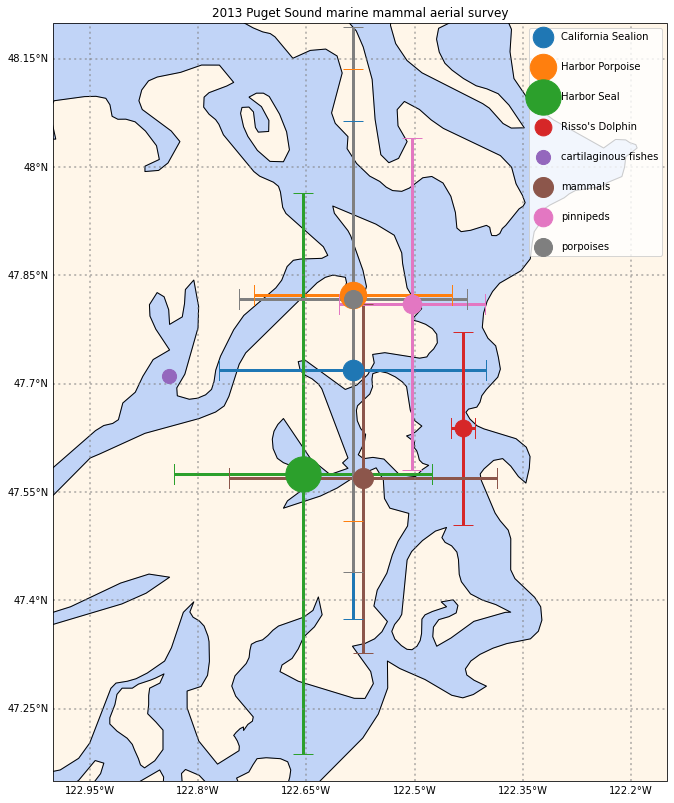

In [ ]:
# Set up Cartopy map
fig = plt.figure(figsize=(11,14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND,color='papayawhip',alpha=0.5)
ax.add_feature(cfeature.OCEAN,color='cornflowerblue',alpha=0.4)
ax.set_extent([-123.0,-122.15,47.15,48.2])
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=2,color='gray',alpha=0.5,linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_title('2013 Puget Sound marine mammal aerial survey')

# Group data by animal name
mm_data_grouped = mm_data.groupby('vernacularName')

# Use loop to iterate over each animal
for animal in list(mm_data_grouped.groups.keys()):
  animal_total_count = mm_data_grouped.sum()['individualCount'].loc[animal]
  animal_avg_lon = mm_data_grouped.mean()['decimalLongitude'].loc[animal]
  animal_avg_lat = mm_data_grouped.mean()['decimalLatitude'].loc[animal]
  animal_std_lon = mm_data_grouped.std()['decimalLongitude'].loc[animal]
  animal_std_lat = mm_data_grouped.std()['decimalLatitude'].loc[animal]

  # Add scatter points, with size corresponding to number of sightings (scaled by the 1/4 power)
  #                     and location corresponding to average location
  #                     and errorbars corresponding to standard deviation of location
  ax.scatter(animal_avg_lon,animal_avg_lat,
             s=200*animal_total_count**0.25,
             label=animal,zorder=3,
             transform=ccrs.PlateCarree())
  ax.errorbar(animal_avg_lon,animal_avg_lat,
              xerr=animal_std_lon,
              yerr=animal_std_lat,
              elinewidth=3,capsize=10)

# Create legend
plt.legend(labelspacing=2);

## Part 2: `Pandas` - correlating, resampling, and smoothing data

### Load weather station data from Seattle and Spokane 

**Data source:** NOAA NCDC [Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/)

**Description:** Daily high/low temperature (in °F) and precipitation (in/day) from 1980-present for SeaTac (station #24233) and Spokane (station #24157).

In [ ]:
# Load CSV
# Note that we're parsing the "eventDate" column as datetimes
#   and setting the "recordNumber" column as the index
wa_filepath = '/content/drive/MyDrive/OCEAN 215 - Autumn \'20/OCEAN 215 - Autumn \'20 - Course documents/Video lesson slides and notebooks/2020-11-22 - lesson #15 data/wa_weather.csv'
wa_data = pd.read_csv(wa_filepath,parse_dates=['DATE'])

# View data
display(wa_data)

,STATION,NAME,DATE,PRCP,TMAX,TMIN
0,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-01,0.22,52,44
1,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-02,0.19,46,37
2,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-03,0.00,46,33
3,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-04,0.13,40,34
4,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",1980-01-05,0.12,39,30
...,...,...,...,...,...,...
29859,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2020-11-15,0.00,47,33
29860,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2020-11-16,0.17,42,35
29861,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2020-11-17,0.02,55,36
29862,USW00024157,"SPOKANE INTERNATIONAL AIRPORT, WA US",2020-11-18,0.09,48,37


In [ ]:
# Divide the data by location into two Pandas DataFrames
seattle = wa_data.loc[wa_data['NAME'] == 'SEATTLE TACOMA AIRPORT, WA US']
spokane = wa_data.loc[wa_data['NAME'] == 'SPOKANE INTERNATIONAL AIRPORT, WA US']

# Make the date column the index for each DataFrame
seattle.set_index('DATE',inplace=True)
spokane.set_index('DATE',inplace=True)

# Confirm that everything worked
display(seattle)

,STATION,NAME,PRCP,TMAX,TMIN
DATE,,,,,
1980-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.22,52,44
1980-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.19,46,37
1980-01-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.00,46,33
1980-01-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.13,40,34
1980-01-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.12,39,30
...,...,...,...,...,...
2020-11-15,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.20,53,46
2020-11-16,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.49,51,46
2020-11-17,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",0.53,63,47


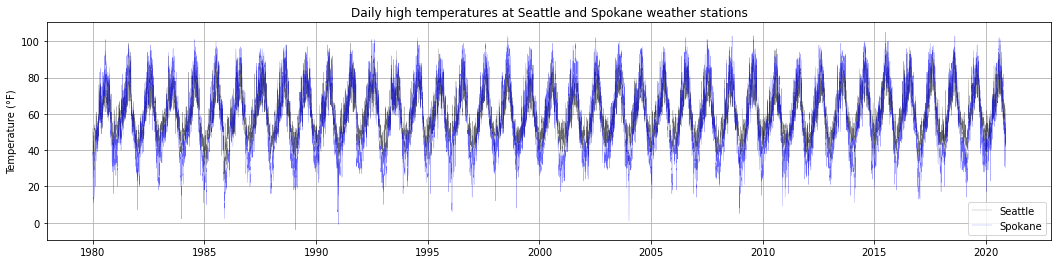

In [ ]:
# Plot of the high temperature data
plt.figure(figsize=(18,4))
plt.plot(seattle['TMAX'].index.values,seattle['TMAX'].values,c='k',lw=0.25,alpha=0.6,label='Seattle')
plt.plot(spokane['TMAX'].index.values,spokane['TMAX'].values,c='b',lw=0.25,alpha=0.6,label='Spokane')
plt.grid()
plt.legend()
plt.ylabel('Temperature (°F)')
plt.title('Daily high temperatures at Seattle and Spokane weather stations');

### Use `.groupby()` to calculate climatologies and annual averages

If a Pandas Series or DataFrame's index has datetimes, it's called a `DatetimeIndex`. `DatetimeIndex` objects have a few useful attributes:

* `.year`
* `.month`
* `.day`
* `.dayofyear`  (day-of-year goes from 1-366)

In [ ]:
# This finds the year for each date
seattle.index.year

Int64Index([1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980,
            ...
            2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020],
           dtype='int64', name='DATE', length=14934)

In [ ]:
# This finds the day-of-year for each date
seattle.index.dayofyear

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            315, 316, 317, 318, 319, 320, 321, 322, 323, 324],
           dtype='int64', name='DATE', length=14934)

In [ ]:
# We can group the data by day-of-year, then calculate the average over each day-of-year, for each column
#
# This type of average is called a "climatology"
seattle_clim = seattle.groupby(seattle.index.dayofyear).mean()
spokane_clim = spokane.groupby(spokane.index.dayofyear).mean()

# See result
display(seattle_clim)

,PRCP,TMAX,TMIN
DATE,,,
1,0.170000,45.878049,36.170732
2,0.225122,45.536585,35.560976
3,0.143415,46.195122,35.926829
4,0.203171,45.975610,35.902439
5,0.211463,45.073171,35.707317
...,...,...,...
362,0.126750,45.425000,35.925000
363,0.188750,44.525000,35.325000
364,0.173000,45.350000,35.275000


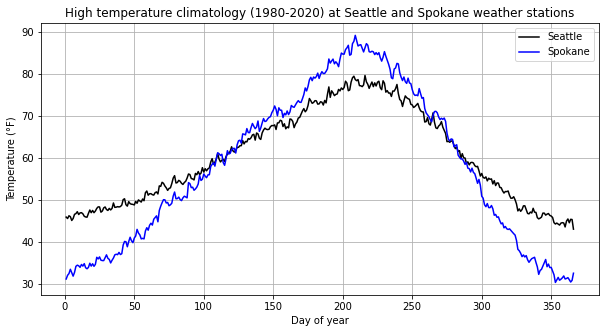

In [ ]:
# Plot of climatologies
plt.figure(figsize=(10,5))
plt.plot(seattle_clim.index,seattle_clim['TMAX'].values,c='k',label='Seattle')
plt.plot(spokane_clim.index,spokane_clim['TMAX'].values,c='b',label='Spokane')
plt.grid()
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Temperature (°F)')
plt.title('High temperature climatology (1980-2020) at Seattle and Spokane weather stations');

In [ ]:
# We can group the data by year, then calculate the annual averages for each column
seattle_ann = seattle.groupby(seattle.index.year).mean()
spokane_ann = spokane.groupby(spokane.index.year).mean()

# See result
display(seattle_ann)

,PRCP,TMAX,TMIN
DATE,,,
1980,0.097268,58.368852,44.314208
1981,0.096986,60.010959,45.287671
1982,0.107726,58.715068,43.978082
1983,0.112137,59.564384,45.824658
1984,0.101066,58.639344,44.338798
1985,0.068849,57.627397,42.273973
1986,0.105041,60.449315,45.367123
1987,0.082000,62.142466,45.142466
1988,0.090109,60.251366,44.568306


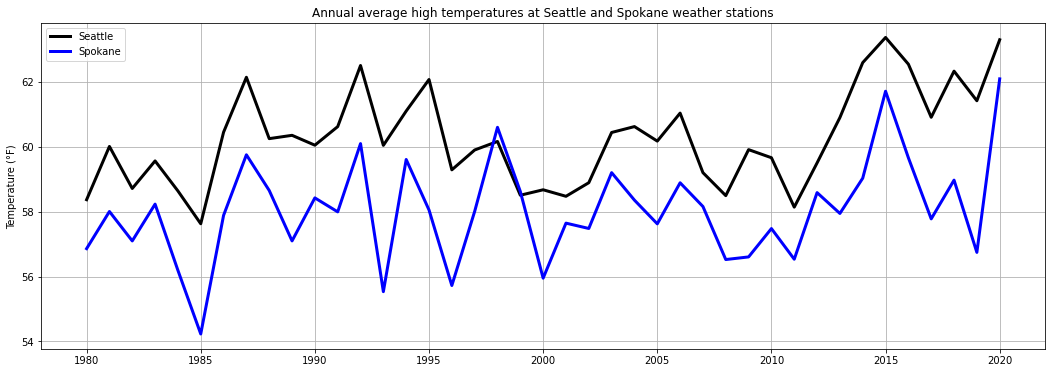

In [ ]:
# Plot of the annual average high temperature data
plt.figure(figsize=(18,6))
plt.plot(seattle_ann['TMAX'].index.values,seattle_ann['TMAX'].values,c='k',lw=3,label='Seattle')
plt.plot(spokane_ann['TMAX'].index.values,spokane_ann['TMAX'].values,c='b',lw=3,label='Spokane')
plt.grid()
plt.legend()
plt.ylabel('Temperature (°F)')
plt.title('Annual average high temperatures at Seattle and Spokane weather stations');

### Calculating correlations using `.corr()`

Recall that a column of a Pandas DataFrame is a Pandas Series.

We can correlate two Pandas Series objects, `s1` and `s2`, using the following syntax:

> `s1.corr(s2)`

The result is the standard Pearson correlation coefficient, $r$.

More commonly, however, you'll use $r^2$. As I introduced in Lesson #14, $r^2$ represents the proportion of variance in one variable that is explained by the other variable.

API documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

In [ ]:
# Correlate annual average high temperatures from Seattle and Spokane
#
# Note that we provide the entire Pandas Series, not just the .values or the .index
r = seattle_ann['TMAX'].corr(spokane_ann['TMAX'])
print('The r^2 value is:',r**2)

The r^2 value is: 0.5435287424617923


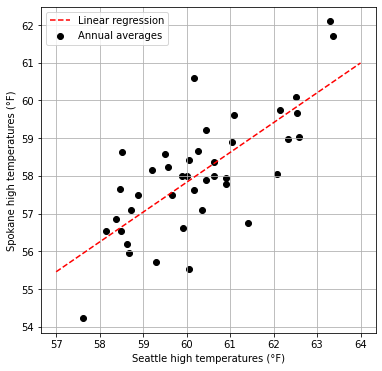

In [ ]:
# In other words, there's clearly a relationship between annual-average temperatures in Seattle
# and Spokane.
#
# This plot shows that close relationship, and also shows the regression line.
#
# The r^2 value tells us that 50% of the variance of annual-average temperatures in Spokane
# can be explained by the annual-average Seattle temperatures.

# Linear regression using SciPy (see Lesson #14 for details)
slope,intercept,_,_,_ = stats.linregress(seattle_ann['TMAX'].values,spokane_ann['TMAX'].values)

# Make plot
plt.figure(figsize=(6,6))
plt.scatter(seattle_ann['TMAX'],spokane_ann['TMAX'],c='k',label='Annual averages')
plt.plot(np.arange(57,65), slope * np.arange(57,65) + intercept,c='r',ls='--',label='Linear regression')
plt.legend()
plt.grid()
plt.xlabel('Seattle high temperatures (°F)')
plt.ylabel('Spokane high temperatures (°F)');

### Changing the time resolution using `.resample()`

We can down-sample the time resolution of a Pandas Series or DataFrame if it has datetimes as its index, i.e. a `DatetimeIndex`.

The function `.resample()` takes a "frequency alias" or "offset alias" as its argument. It behaves similar to `.groupby()`, so after you group the data, you have to apply a function like `.mean()`, `.max()`, or `.sum()`.

Here are the available frequency aliases: https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases

Some common options are:
* 'H': hourly frequency
* 'D': daily frequency
* 'W': weekly frequency
* 'MS': monthly frequency (use start of month as resulting date)
* 'YS': yearly frequency (use start of year as resulting date)

API documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

In [ ]:
# Calculate annual averages using .resample() instead of .groupby()
seattle['TMAX'].resample('YS').mean()

DATE
1980-01-01    58.368852
1981-01-01    60.010959
1982-01-01    58.715068
1983-01-01    59.564384
1984-01-01    58.639344
1985-01-01    57.627397
1986-01-01    60.449315
1987-01-01    62.142466
1988-01-01    60.251366
1989-01-01    60.353425
1990-01-01    60.049315
1991-01-01    60.621918
1992-01-01    62.505464
1993-01-01    60.043836
1994-01-01    61.101370
1995-01-01    62.073973
1996-01-01    59.289617
1997-01-01    59.901370
1998-01-01    60.164384
1999-01-01    58.506849
2000-01-01    58.674863
2001-01-01    58.473973
2002-01-01    58.893151
2003-01-01    60.441096
2004-01-01    60.622951
2005-01-01    60.175342
2006-01-01    61.038356
2007-01-01    59.202740
2008-01-01    58.494536
2009-01-01    59.912329
2010-01-01    59.663014
2011-01-01    58.139726
2012-01-01    59.502732
2013-01-01    60.901370
2014-01-01    62.594521
2015-01-01    63.369863
2016-01-01    62.546448
2017-01-01    60.909589
2018-01-01    62.331507
2019-01-01    61.419178
2020-01-01    63.299383
Freq: AS-JA

### Smoothing data using `.rolling()` averages

A common technique to smooth a time series (or other data) is to calculate a rolling average, also called a running average, running mean, or moving average:

> `.rolling(window,min_periods=1,center=False)`

* `window` specifies the size of the moving window in number of rows
* `min_periods` specifies the minimum number of rows required to have data (otherwise the result is np.NaN); this is important at the start and end of the time series
* if `center` is True (recommended), the date will be set to center of each window; if False, the date will be set to the end of each window

Again, `.rolling()` behaves similar to `.groupby()` and `.resample()` in that you have to apply a function like `.mean()` or `.median()` to the grouped data to get a result.

API documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

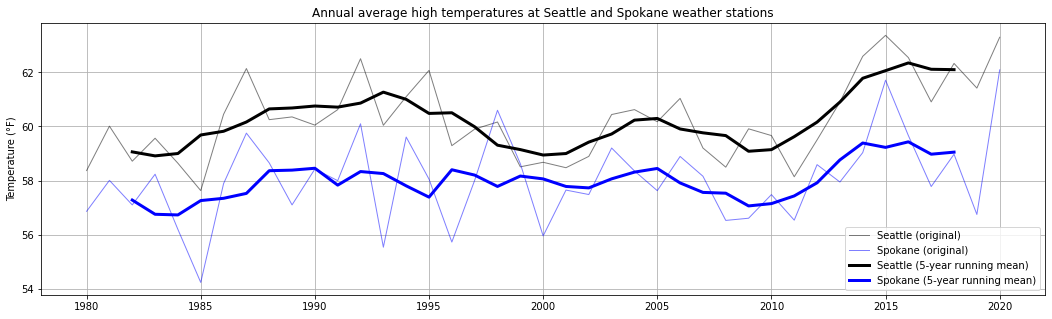

In [ ]:
# Smooth annual average temperatures using a 5-year running mean
seattle_ann_rm = seattle_ann['TMAX'].rolling(window=5,center=True).mean()
spokane_ann_rm = spokane_ann['TMAX'].rolling(window=5,center=True).mean()

# Plot
plt.figure(figsize=(18,5))
plt.plot(seattle_ann['TMAX'].index.values,seattle_ann['TMAX'].values,c='k',lw=1,alpha=0.5,label='Seattle (original)')
plt.plot(spokane_ann['TMAX'].index.values,spokane_ann['TMAX'].values,c='b',lw=1,alpha=0.5,label='Spokane (original)')
plt.plot(seattle_ann_rm,c='k',lw=3,label='Seattle (5-year running mean)')
plt.plot(spokane_ann_rm,c='b',lw=3,label='Spokane (5-year running mean)')
plt.grid()
plt.legend()
plt.ylabel('Temperature (°F)')
plt.title('Annual average high temperatures at Seattle and Spokane weather stations');

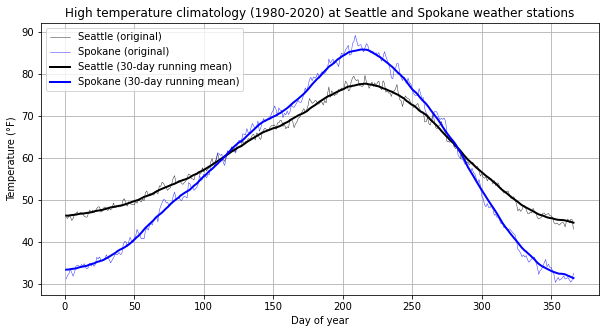

In [ ]:
# Smooth high temperature climatologies using a 30-day running mean
seattle_clim_rm = seattle_clim['TMAX'].rolling(window=30,center=True,min_periods=1).mean()
spokane_clim_rm = spokane_clim['TMAX'].rolling(window=30,center=True,min_periods=1).mean()

# Plot of climatologies
plt.figure(figsize=(10,5))
plt.plot(seattle_clim.index,seattle_clim['TMAX'].values,c='k',lw=0.5,alpha=0.8,label='Seattle (original)')
plt.plot(spokane_clim.index,spokane_clim['TMAX'].values,c='b',lw=0.5,alpha=0.8,label='Spokane (original)')
plt.plot(seattle_clim_rm,c='k',lw=2,label='Seattle (30-day running mean)')
plt.plot(spokane_clim_rm,c='b',lw=2,label='Spokane (30-day running mean)')
plt.grid()
plt.legend()
plt.xlabel('Day of year')
plt.ylabel('Temperature (°F)')
plt.title('High temperature climatology (1980-2020) at Seattle and Spokane weather stations');